In [1]:
"""
Copyright (c) 2022 Magdalena Fuentes, Bea Steers, Luca Bondi(Robert Bosch GmbH), Julia Wilkins
All rights reserved.

This source code is licensed under the BSD-3-Clause license found in the
LICENSE file in the root directory of this source tree.
"""

%load_ext autoreload
%autoreload 2

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
from tqdm import tqdm
import glob
from moviepy.editor import AudioFileClip,VideoFileClip,CompositeVideoClip, VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


import sys
sys.path.append('../')
from utils import draw_detections, draw_annot_on_spec
from project_params import frame_width, fov, num_regions, labels_period
from eval import iou_score, compute_file_gt, score_file, load_predictions, load_index

### Load index JSON
Add your filepath below!

In [3]:
index = load_index("../index/Urbansas.json")

Length of index:  1080


### Load annotations files 
Put your filepath below!

In [5]:
URBANSASPATH = '/Users/mf3734/sound_datasets/urbansas/'
VIDEOPATH = os.path.join(URBANSASPATH, 'video_2fps')
AUDIOPATH = os.path.join(URBANSASPATH, 'audio')
audio_annotations = pd.read_csv(os.path.join(URBANSASPATH, 'annotations', 'audio_annotations.csv'))
video_annotations = pd.read_csv(os.path.join(URBANSASPATH, 'annotations', 'video_annotations.csv'))
videos = np.sort(video_annotations.filename.unique())

In [6]:
classes = ['bus', 'car', 'motorbike', 'truck']
print(classes)

['bus', 'car', 'motorbike', 'truck']


### Load params from project config files

In [7]:
# Params
print('frame_width:', frame_width)
print('fov:', fov)
print('num_regions:', num_regions)
print('labels_period (s):', labels_period)


fps = int(1/labels_period)
# Define angles
angles = np.linspace(-fov/2, fov/2, num_regions)

frame_width: 1280
fov: 120
num_regions: 5
labels_period (s): 0.5


## Visualize annotations from index and original data

In [8]:
import functools

def fl_indexed(clip, func, *a, offset=0, **kw):
    '''Utility for iterating over a clip with its frame ID instead of timestamp.'''
    fps = clip.fps
    return clip.fl(lambda get, t: func(get(t), int((t+offset)*fps), *a, **kw))


def fl_dets(clip, df, offset=0, **kw):
    '''Draw detections from a clip.'''
    return fl_indexed(clip, draw_detections, df, offset=offset, **kw)

@functools.lru_cache()
def load_drawn_video(video, FPS=None):
    print('loading', video, '...')
    clip = VideoFileClip(os.path.join(VIDEOPATH, f'{video}.mp4'))
    audio_clip = AudioFileClip(os.path.join(AUDIOPATH, f'{video}.wav'))
    if FPS:
        clip = clip.set_fps(FPS)
    print('drawing annotations...')
    return fl_dets(clip, video_annotations[video_annotations.filename == video]).set_audio(audio_clip)

In [65]:
tqdm._instances.clear()
filename = 'lyon1045_40975'#lyon1045_41811'
i = [n for n, v in enumerate(videos) if v==filename][0]
uid = [k for k,v in index.items() if v['path']==f'audio/{filename}.wav'][0]
FPS = 2

fname = videos[i]
print(f"==Video name is {fname} ==\n")
load_drawn_video(fname, FPS).ipython_display(loop=True, autoplay=True, width = 720)

==Video name is lyon1045_40975 ==

loading lyon1045_40975 ...
drawing annotations...
Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [66]:
# Load original audio and play it
print("File: ", filename)
filepath = os.path.join(AUDIOPATH, f'{filename}.wav')
file_audio_annot = audio_annotations[audio_annotations.filename==filename]
file_video_annot = video_annotations[video_annotations.filename==filename]
y, sr = librosa.load(filepath, sr=None, mono=False)

File:  lyon1045_40975


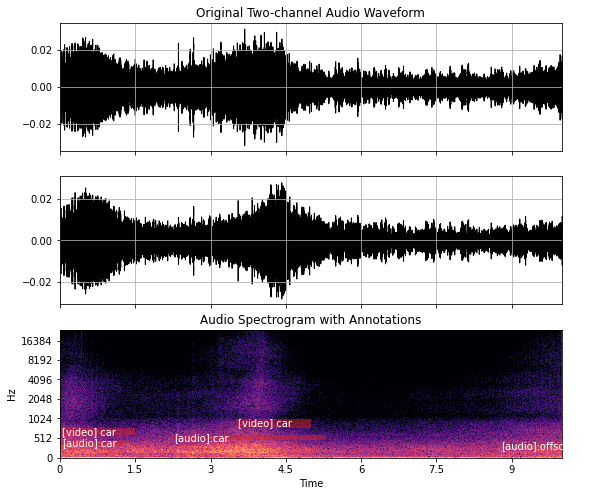

In [67]:
draw_annot_on_spec(y, sr, file_audio_annot, file_video_annot, start=0, end=10)

# Visualize Prediction Data

### Load index and predictions

In [43]:
predpath_list = [
    "../predictions/urbansas_f0_point_sources/Urbansas-f0-epoch060.h5",
    "../predictions/urbansas_f1_point_sources/Urbansas-f1-epoch155.h5",
    "../predictions/urbansas_f2_point_sources/Urbansas-f2-epoch137.h5",
    "../predictions/urbansas_f3_point_sources/Urbansas-f3-epoch132.h5",
    "../predictions/urbansas_f4_point_sources/Urbansas-f4-epoch136.h5",
]
point_sources = 'point_sources' in predpath_list[0]
pred = {}
for predpath in predpath_list:
    pred.update(load_predictions(predpath))
print('Predictions are point sources', point_sources)
print(f'Loaded {len(pred)} predictions')

Predictions are point sources True
Loaded 1080 predictions


### Visualize...

In [71]:
# Get the gth for this file
gth_uid = compute_file_gt(index, uid, classes=classes, point_sources=point_sources)
print(gth_uid.shape)

# Pick if you want to show the thresholded version or unthresholded
thresholded = False
tau = 0.05

(20, 4, 5)


Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


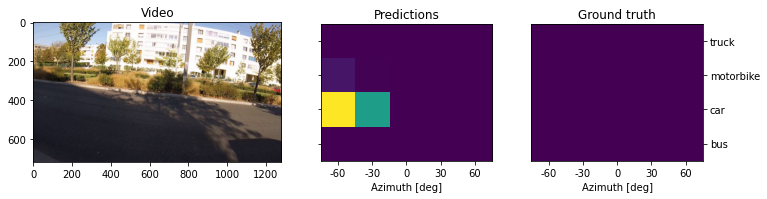

In [72]:
# This will show the video side-by-side with the regions moving through the video
file_video = VideoFileClip(os.path.join(VIDEOPATH, f'{filename}.mp4')).set_start(0).set_end(10)
fig,axs = plt.subplots(1,3, figsize=(12,4), gridspec_kw={'width_ratios': [1.45, 1, 1]})

def make_frame(frame_time:float):
    axs[0].clear()
    axs[0].imshow(file_video.get_frame(frame_time))
    axs[0].set_title('Video')

    if thresholded:
        mask = ((pred[uid]['pred'] > tau)**1)[int(frame_time*fps), :, :]
    else:
        mask = pred[uid]['pred'][int(frame_time*fps), :, :]

    axs[1].clear()
    axs[1].imshow(mask)
    axs[1].set_ylim(-0.5, len(classes)-0.5)
    axs[1].set_xlim(-0.5,num_regions-0.5)
    axs[1].set_yticklabels([])
    axs[1].set_xticks(np.arange(len(angles)))
    axs[1].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[1].set_xlabel('Azimuth [deg]')
    axs[1].set_title('Predictions')
    
    axs[2].clear()
    axs[2].imshow(gth_uid[int(frame_time*fps), :, :])
    axs[2].set_ylim(-0.5, len(classes)-0.5)
    axs[2].set_xlim(-0.5,num_regions-0.5)
    axs[2].set_yticks(np.arange(len(classes)))
    axs[2].set_yticklabels(classes)
    axs[2].set_xticks(np.arange(len(angles)))
    axs[2].set_xticklabels([ f'{a:.0f}' for a in angles])
    axs[2].set_xlabel('Azimuth [deg]')
    axs[2].yaxis.tick_right()
    axs[2].set_title('Ground truth')

    return mplfig_to_npimage(fig)

# Render and display
file_audio_clip = AudioFileClip(os.path.join(AUDIOPATH, f'{filename}.wav'))#.set_start(start).set_end(end)
file_video_pred = VideoClip(make_frame, duration=file_video.duration).set_audio(file_audio_clip)
file_video_pred.ipython_display(width=960,fps=fps)


### Get the IoU score for this file

In [70]:
if point_sources:
    source_type = 'pointwise'
else:
    source_type = 'boxwise'

scores = pd.DataFrame({})
for frame_type in ['active', 'inactive', 'all']:
    scores = pd.concat([scores, score_file(gth_uid, pred[uid]['pred'], uid, tau, class_list=classes, model_type=source_type,
               labels_period=labels_period, file_duration=file_video.duration, frame_type=frame_type)])
scores

bus       car  motorbike  truck score   tau frame_type  uid model_type
0  NaN  0.250000        NaN    NaN   iou  0.05     active  496  pointwise
0  1.0  0.642857       0.95    1.0   iou  0.05   inactive  496  pointwise
0  1.0  0.525000       0.95    1.0   iou  0.05        all  496  pointwise